In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.linalg import solve
from scipy.sparse import identity
from qpsolvers import solve_qp
from scipy.spatial import ConvexHull

# SPA
Scalable Probabilistic Approximation is a technique that allows to find a set of points $S$ which can be used to describe some data $X$.

$$\mathcal{L}_\text{SPA}=\Vert X-S\Gamma\Vert_F^2 + \varepsilon_S \Phi_S(S)$$

The function $\Phi_S$ can be chosen arbitrarily. If we are interested in finding $S$, such that the polytope generated by $S$ has the smallest convex hull, the following can be used:
$$\Phi_S(S)=\frac{1}{DK(K-1)}\sum_{d,k_1,k_2=1}^{D,K,K} (S_{d,k_1}-S_{d,k_2})^2$$
which does nothing else than adding penalty based on pairwise distances between the reference points $S$.

Let us once again generate blobs. In this case, we are not interested in their label, but simply to have a point cloud to approximate.

Text(0, 0.5, '$x_2$')

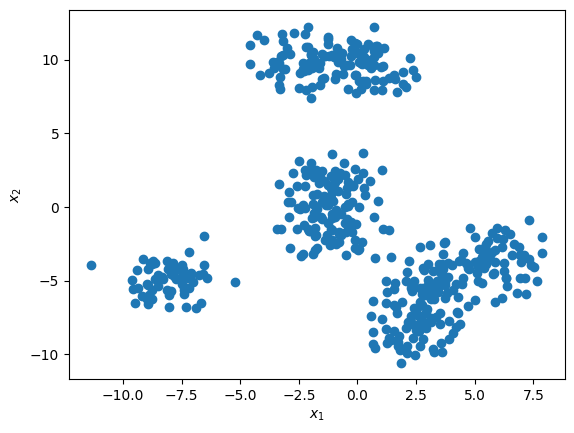

In [2]:
X,y = make_blobs(
    n_samples=500,
    centers=8
)
plt.scatter(X[:,0], X[:,1])
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

## Solutions
Note that the loss function:

- Introduces a change in the solution of $S$ (i.e., k-means solution is not optimal)
- Jensen inequality is **not** used ($\Gamma$ is inside the norm).

### S-step
The optimal value of $S$ can be found in each iteration as:
$$S^* = X\Gamma^\top H_{\varepsilon_S}^{-1}$$
where $$H_{\varepsilon_S}:=\Gamma\Gamma^\top + \frac{2\varepsilon^2_S}{nK(K-1)}(KI_{K,K}-\mathbf{1}_{K,K}).$$

### $\Gamma$-step
For the $\Gamma$ step, the problem is separable in $T$. As such, we have to solve $T$ independent QP problems of the form:
$$\gamma_t^* = \arg_\gamma \min \frac{1}{2} \gamma^\top A\gamma - b_t^\top \gamma$$
such that $\gamma \in \Omega_\gamma$
$$\Omega_\gamma := \{\gamma \in \mathbb{R}^K | B\gamma=c, \gamma \geq 0 \}$$
where
$$A:=2S^\top S$$
$$b_t:=S^\top x_t$$
$$B:=\mathbf{1}_K^\top$$
$$c:=1$$

In [ ]:
class spa_demo:

    def __init__(self,K, epsilon, max_iters=200, tol=1e-8):
        self.K=K
        self.epsilon=epsilon
        self.max_iters = max_iters
        self.tol=tol 

    def __repr__(self):
        return "I am a SPA model with K=%d, and epsilon=%.2f" %(self.K, self.epsilon)

    def fit(self, X):
        T,D = X.shape
        # As with kmeans, we create centroids and affiliations
        self.S = X[np.random.randint(0,T, self.K),:]
        print(self.S.shape)
        self.G = np.zeros((T, self.K))

        # Create regularization matrix for S
        self.Hreg = (2/(D*self.K*(self.K-1))) * (self.K*identity(self.K)-np.ones((self.K,self.K)))

        # Create constraints for QP
        self.A = np.ones(self.K)
        self.b = np.ones((1,1))
        self.lb = np.zeros(self.K)

        i=0
        delta=np.inf
        prev_error=np.inf
        while i<self.max_iters and delta>self.tol:

            i+=1

            # # Update Gamma
            self.Ht = 2*(self.S @ self.S.T) # K by K
            self.bgt = 2*(self.S @ X.T) # K by T
            #print("this is bgt", self.bgt[:,0]) 
            for t in range(T):
                self.G[t,:] = solve_qp(self.Ht, self.bgt[:,t], A=self.A, b=self.b, lb=self.lb, solver="clarabel")
                #print("this is G", self.G)

            # # Update S
            HS = self.G.T @ self.G + self.Hreg
            
            rhs = self.G.T @ X                     # rechte Seite G^T X
            self.S = np.linalg.solve(HS, rhs)  # löst HS @ S^T = G^T X
            
            #print("shape S",self.S)#TODO: fix this (you can use `solve`)

            

        self.reconstruction = self.G @ self.S

In [4]:
mod = spa_demo(K=5, epsilon=1e-2, max_iters=50)
mod.fit(X)

(5, 2)


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:28: SparseConversionWarning: Converted matrix 'P' of your problem to scipy.sparse.csc_matrix to pass it to solver 'clarabel'; for best performance, build your matrix as a csc_matrix directly.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:28: SparseConversionWarning: Converted matrix 'A' of your problem to scipy.sparse.csc_matrix to pass it to solver 'clarabel'; for best performance, build your matrix as a csc_matrix directly.
  warnings.warn(


Now, we can inspect the reconstruction of the original data points, and overlay the convex hull of the reference points (i.e., the convex polytope that is used in the reconstruction)

[[  2.76150401 -12.16577041]
 [ -2.41429836  12.07279937]
 [  4.02712826  -0.8718762 ]
 [-11.33818323  -3.85036295]
 [ 11.71484756   3.42017601]]


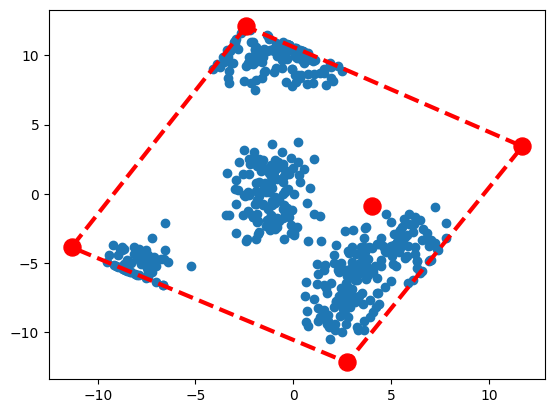

In [5]:
# Plot the convex hull of the reference points
hull = ConvexHull(mod.S)
vert_plot = np.hstack([hull.vertices.flatten(), hull.vertices[0]])
plt.plot(mod.S[vert_plot,0], mod.S[vert_plot,1], 'r--', lw=3)

# Plot reconstruction
plt.scatter(mod.reconstruction[:,0], mod.reconstruction[:,1])


# Plot reference points
print(mod.S)
plt.scatter(mod.S[:,0], mod.S[:,1], color="red", s=150)

The position of each point inside of the convex hull can be expressed exactly as a convex combination of the reference points. In the following plot, we can inspect the coefficients for such combination (for a single reference point at a time).

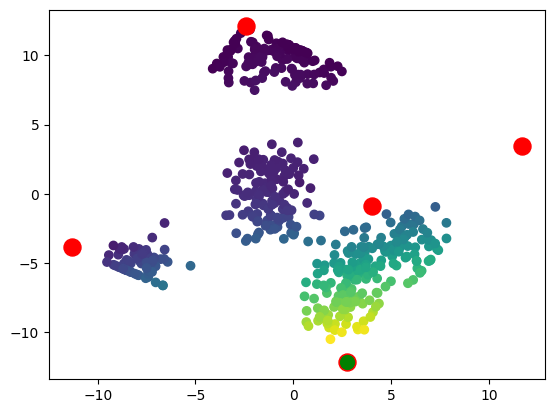

In [6]:
which_point = 0

plt.scatter(mod.reconstruction[:,0], mod.reconstruction[:,1], c=mod.G[:,which_point])
plt.scatter(mod.S[:,0], mod.S[:,1], color="red", s=150)
plt.scatter(mod.S[which_point,0], mod.S[which_point,1], color="green", s=100)